In [1]:
# # Run this and then restart the kernel at the start of each session to install
# # 'teotil3' in development mode
# !pip install -e /home/jovyan/projects/teotil3/

In [2]:
import os

import altair as alt
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
import rioxarray as rio
import teotil3 as teo

alt.data_transformers.disable_max_rows()
plt.style.use("ggplot")

# Task 2.1: Update TEOTIL "core" datasets

## Part B: Summarise and combine regine-level data

From the proposal text:

> **Oppgave 2.1: Oppdatere og forbedre kjernedatasett**
> 
> Følgende datasett vil bli oppdatert:
>  * Nedbørfeltsgrenser (reginefelt fra NVE)
>  * Innsjødatabase og innsjødyp (fra NVE)
>  * Elvenett (ELVIS og Hovedelv-segmenter fra NVE)
>  * Arealbruk (AR50 fra NIBIO)
>  * Atmosfærisk avsetning av N (fra NILU)
>  * Administrative grenser (fylker og kommuner fra Geonorge)
>  
> Reginefeltene vil bli brukt til å oppsummere de andre datasettene, for eksempel ved å beregne arealbruksstatistikk og gjennomsnittlig atmosfærisk deponering for hvert reginefelt og ved å skjære fylke- og kommunegrensene. Så langt det er mulig vil arbeidsflyten være skriptet for å gjøre den repeterbar og enklere å vedlikeholde ettersom datasett oppdateres i fremtiden (selv om noe manuelt arbeid fortsatt vil være nødvendig).

## 1. Download the latest datasets

As of 2022, most datasets can be downloaded in **FGDB format**, which is cleaner and more efficient than using shapefiles. The exception is the administrative boundaries, some of which are only available in SOSI format. These therefore need processing first - see notebook `T2-1a`. All datasets are available in **ETRS89-based UTM Zone 33N**.

The following datasets can be downloaded from NVE [here](http://nedlasting.nve.no/gis/):

 * Elv
    - Hovedelv
    - Elvenett
 * Innsjø
    - Innsjø
    - Dybdedata - innsjø
 * Nedbørfelt
    - Vassdragsområder
    - Nedbørfelt til hav
    - Sidenedbørfelt
    - Regine enhet
 * Vanndirektivet
    - Select all options

Administrative boundaries can be downloaded from [Geonorge](https://www.geonorge.no/):

 * Administrative enheter fylker
 * Administrative enheter kommuner
 * Administrative enheter - historiske versjoner (for years before 2022)
 
Land cover can be downloaded from [NIBIO's Kilden](https://kart8.nibio.no/nedlasting/dashboard):

 * Arealressurskart - AR50


**All datasets were downloaded during June 2022 and added to `shared/teotil3/core_data` on JupyterHub**.

In [3]:
# Set periods of interest for fylke and kommune boundaries
admin_years = range(2014, 2025)

In [4]:
# Get input file paths
data_fold = r"/home/jovyan/shared/common/teotil3/core_data"
nve_gdb = os.path.join(data_fold, "hydrology", "NVEData.gdb")
ar50_gdb = os.path.join(data_fold, "land_cover", "nibio_ar50.gdb")
ro_grid_path = (
    r"/home/jovyan/shared/common/teotil3/nve_hbv_data/runoff_1991-2020_mm_year.tif"
)
admin_gpkg = os.path.join(
    data_fold, "administrative", "admin_data.gpkg"
)  # Created by notebook T2-1a

# Output paths
teo_gpkg = os.path.join(data_fold, "tidied", "teotil3_data.gpkg")
reg_csv = os.path.join(data_fold, "tidied", "regines.csv")

## 1. Read regine polygons

#### Update 11.12.2023

NIBIO have used a different set of regine polygons for their modelling. The regines change regularly and ideally we should be able to update them easily, but unfortunately it is not easy for NIBIO to update their workflow. I will therefore change TEOTIL to use the NIBIO regines.

NIBIO downloaded the regines in shapefile format, whereas my code expects a geodatabase. I have therefore converted the NIBIO shapefile to a geopackage with the correct field names, which I will use in this notebook (see `process_nibio_regines.ipynb` for details). 

**The commented-out code above using `teo.preprocessing.read_raw_regine_data` should be used again in future when I update the regines using the standard workflow**.

In [5]:
# reg_gdf = teo.preprocessing.read_raw_regine_data(nve_gdb, "RegineEnhet")
# reg_gdf.head()

In [6]:
nib_gpkg = os.path.join(data_fold, "hydrology", "nibio_regines.gpkg")
reg_gdf = gpd.read_file(nib_gpkg, layer="RegineEnhetNibio", driver="GPKG")
reg_gdf.head()

/opt/conda/lib/python3.11/site-packages/pyogrio/raw.py:194: RuntimeWarning: driver GPKG does not support open option DRIVER
  result = ogr_read(


regine vassom  a_cat_poly_km2  upstr_a_km2  \
0    001.10    001        1.442790         0.00   
1   001.1A1    001        1.432479       777.90   
2  001.1A20    001        0.340160       777.90   
3  001.1A2A    001       17.647822        58.96   
4  001.1A2B    001       41.298255        41.30   

                                            geometry  
0  POLYGON ((297006.83 6543966.95, 297169.29 6543...  
1  POLYGON ((297505.44 6543157.79, 297543.1 65430...  
2  POLYGON ((297770.368 6543429.036, 297787.114 6...  
3  POLYGON ((299678.37 6544460.32, 299667.22 6544...  
4  POLYGON ((303353.46 6552989.33, 303341.62 6552...

## 2. Assign regines to fylker, kommuner and OSPAR regions

Each regine is assigned to a single fylke, kommune and OSPAR region. For regines overlapping several fylker/kommuner, the fylke/kommune with the largest proportion of the regine by area is chosen. 

**Note:** NVE's regine dataset extends beyond Norway to cover whole catchments, whereas the fylke and kommune datasets stop at the border. Some regines are therefore entirely beyond the edge of the administrative data, or have only a tiny fraction of their total area within Norway. For regines with no overlapping fylke or kommune, I have assigned `fylnr = komnr = -1`.

The code below attempts to process administrative boundaries for all years, but some years fail due to SOSI issues (possibly related to [this](https://github.com/shapely/shapely/issues/1364) GEOS problem). Everything works for 2014 onwards, though, which is OK for TEOTIL3 (for 2013, the administrative boundaries are assumed to be the same as in 2014, which I think is correct). For future processing, extend `admin_gpkg` with the latest data and then re-run this notebook.

In [7]:
%%time

# Assign OSPAR regions
reg_gdf = teo.preprocessing.assign_regines_to_ospar_regions(reg_gdf)

# Assign administrative regions
for admin_year in admin_years:
    print("####################################################################")
    print(f"Processing {admin_year}...")
    reg_gdf = teo.preprocessing.assign_regines_to_administrative_units(
        reg_gdf, admin_gpkg, admin_year
    )
    reg_gdf.rename(
        {"komnr": f"komnr_{admin_year}", "fylnr": f"fylnr_{admin_year}"},
        axis="columns",
        inplace=True,
    )

reg_gdf.head()

####################################################################
Processing 2014...
Processing kommuner


/opt/conda/lib/python3.11/site-packages/pyogrio/raw.py:194: RuntimeWarning: driver GPKG does not support open option DRIVER
  result = ogr_read(


   428 kommuner.
   23931 regines.
   32114 intersected polygons.


/home/jovyan/projects/teotil3/teotil3/preprocessing.py:154: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  reg_gdf[col_name].fillna("-1", inplace=True)
/opt/conda/lib/python3.11/site-packages/pyogrio/raw.py:194: RuntimeWarning: driver GPKG does not support open option DRIVER
  result = ogr_read(


   23648 regines assigned to kommuner.
Processing fylker
   19 fylker.
   23931 regines.
   25171 intersected polygons.


/home/jovyan/projects/teotil3/teotil3/preprocessing.py:154: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  reg_gdf[col_name].fillna("-1", inplace=True)
/opt/conda/lib/python3.11/site-packages/pyogrio/raw.py:194: RuntimeWarning: driver GPKG does not support open option DRIVER
  result = ogr_read(


   23648 regines assigned to fylker.
####################################################################
Processing 2015...
Processing kommuner
   428 kommuner.
   23931 regines.
   32110 intersected polygons.


/home/jovyan/projects/teotil3/teotil3/preprocessing.py:154: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  reg_gdf[col_name].fillna("-1", inplace=True)
/opt/conda/lib/python3.11/site-packages/pyogrio/raw.py:194: RuntimeWarning: driver GPKG does not support open option DRIVER
  result = ogr_read(


   23648 regines assigned to kommuner.
Processing fylker
   19 fylker.
   23931 regines.
   25171 intersected polygons.


/home/jovyan/projects/teotil3/teotil3/preprocessing.py:154: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  reg_gdf[col_name].fillna("-1", inplace=True)
/opt/conda/lib/python3.11/site-packages/pyogrio/raw.py:194: RuntimeWarning: driver GPKG does not support open option DRIVER
  result = ogr_read(


   23648 regines assigned to fylker.
####################################################################
Processing 2016...
Processing kommuner
   428 kommuner.
   23931 regines.
   32111 intersected polygons.


/home/jovyan/projects/teotil3/teotil3/preprocessing.py:154: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  reg_gdf[col_name].fillna("-1", inplace=True)
/opt/conda/lib/python3.11/site-packages/pyogrio/raw.py:194: RuntimeWarning: driver GPKG does not support open option DRIVER
  result = ogr_read(


   23648 regines assigned to kommuner.
Processing fylker
   19 fylker.
   23931 regines.
   25171 intersected polygons.


/home/jovyan/projects/teotil3/teotil3/preprocessing.py:154: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  reg_gdf[col_name].fillna("-1", inplace=True)
/opt/conda/lib/python3.11/site-packages/pyogrio/raw.py:194: RuntimeWarning: driver GPKG does not support open option DRIVER
  result = ogr_read(


   23648 regines assigned to fylker.
####################################################################
Processing 2017...
Processing kommuner
   426 kommuner.
   23931 regines.
   32102 intersected polygons.


/home/jovyan/projects/teotil3/teotil3/preprocessing.py:154: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  reg_gdf[col_name].fillna("-1", inplace=True)
/opt/conda/lib/python3.11/site-packages/pyogrio/raw.py:194: RuntimeWarning: driver GPKG does not support open option DRIVER
  result = ogr_read(


   23648 regines assigned to kommuner.
Processing fylker
   19 fylker.
   23931 regines.
   25171 intersected polygons.


/home/jovyan/projects/teotil3/teotil3/preprocessing.py:154: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  reg_gdf[col_name].fillna("-1", inplace=True)
/opt/conda/lib/python3.11/site-packages/pyogrio/raw.py:194: RuntimeWarning: driver GPKG does not support open option DRIVER
  result = ogr_read(


   23648 regines assigned to fylker.
####################################################################
Processing 2018...
Processing kommuner
   422 kommuner.
   23931 regines.
   32079 intersected polygons.


/home/jovyan/projects/teotil3/teotil3/preprocessing.py:154: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  reg_gdf[col_name].fillna("-1", inplace=True)
/opt/conda/lib/python3.11/site-packages/pyogrio/raw.py:194: RuntimeWarning: driver GPKG does not support open option DRIVER
  result = ogr_read(


   23648 regines assigned to kommuner.
Processing fylker
   18 fylker.
   23931 regines.
   25102 intersected polygons.


/home/jovyan/projects/teotil3/teotil3/preprocessing.py:154: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  reg_gdf[col_name].fillna("-1", inplace=True)
/opt/conda/lib/python3.11/site-packages/pyogrio/raw.py:194: RuntimeWarning: driver GPKG does not support open option DRIVER
  result = ogr_read(


   23648 regines assigned to fylker.
####################################################################
Processing 2019...
Processing kommuner
   422 kommuner.
   23931 regines.
   32080 intersected polygons.


/home/jovyan/projects/teotil3/teotil3/preprocessing.py:154: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  reg_gdf[col_name].fillna("-1", inplace=True)
/opt/conda/lib/python3.11/site-packages/pyogrio/raw.py:194: RuntimeWarning: driver GPKG does not support open option DRIVER
  result = ogr_read(


   23648 regines assigned to kommuner.
Processing fylker
   18 fylker.
   23931 regines.
   25089 intersected polygons.


/home/jovyan/projects/teotil3/teotil3/preprocessing.py:154: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  reg_gdf[col_name].fillna("-1", inplace=True)
/opt/conda/lib/python3.11/site-packages/pyogrio/raw.py:194: RuntimeWarning: driver GPKG does not support open option DRIVER
  result = ogr_read(


   23648 regines assigned to fylker.
####################################################################
Processing 2020...
Processing kommuner
   356 kommuner.
   23931 regines.
   31369 intersected polygons.


/home/jovyan/projects/teotil3/teotil3/preprocessing.py:154: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  reg_gdf[col_name].fillna("-1", inplace=True)
/opt/conda/lib/python3.11/site-packages/pyogrio/raw.py:194: RuntimeWarning: driver GPKG does not support open option DRIVER
  result = ogr_read(


   23648 regines assigned to kommuner.
Processing fylker
   11 fylker.
   23931 regines.
   24671 intersected polygons.


/home/jovyan/projects/teotil3/teotil3/preprocessing.py:154: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  reg_gdf[col_name].fillna("-1", inplace=True)
/opt/conda/lib/python3.11/site-packages/pyogrio/raw.py:194: RuntimeWarning: driver GPKG does not support open option DRIVER
  result = ogr_read(


   23648 regines assigned to fylker.
####################################################################
Processing 2021...
Processing kommuner
   356 kommuner.
   23931 regines.
   31368 intersected polygons.


/home/jovyan/projects/teotil3/teotil3/preprocessing.py:154: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  reg_gdf[col_name].fillna("-1", inplace=True)
/opt/conda/lib/python3.11/site-packages/pyogrio/raw.py:194: RuntimeWarning: driver GPKG does not support open option DRIVER
  result = ogr_read(


   23648 regines assigned to kommuner.
Processing fylker
   11 fylker.
   23931 regines.
   24671 intersected polygons.


/home/jovyan/projects/teotil3/teotil3/preprocessing.py:154: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  reg_gdf[col_name].fillna("-1", inplace=True)
/opt/conda/lib/python3.11/site-packages/pyogrio/raw.py:194: RuntimeWarning: driver GPKG does not support open option DRIVER
  result = ogr_read(


   23648 regines assigned to fylker.
####################################################################
Processing 2022...
Processing kommuner
   356 kommuner.
   23931 regines.
   31369 intersected polygons.


/home/jovyan/projects/teotil3/teotil3/preprocessing.py:154: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  reg_gdf[col_name].fillna("-1", inplace=True)
/opt/conda/lib/python3.11/site-packages/pyogrio/raw.py:194: RuntimeWarning: driver GPKG does not support open option DRIVER
  result = ogr_read(


   23648 regines assigned to kommuner.
Processing fylker
   11 fylker.
   23931 regines.
   24671 intersected polygons.


/home/jovyan/projects/teotil3/teotil3/preprocessing.py:154: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  reg_gdf[col_name].fillna("-1", inplace=True)
/opt/conda/lib/python3.11/site-packages/pyogrio/raw.py:194: RuntimeWarning: driver GPKG does not support open option DRIVER
  result = ogr_read(


   23648 regines assigned to fylker.
####################################################################
Processing 2023...
Processing kommuner
   356 kommuner.
   23931 regines.
   31370 intersected polygons.


/home/jovyan/projects/teotil3/teotil3/preprocessing.py:154: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  reg_gdf[col_name].fillna("-1", inplace=True)
/opt/conda/lib/python3.11/site-packages/pyogrio/raw.py:194: RuntimeWarning: driver GPKG does not support open option DRIVER
  result = ogr_read(


   23648 regines assigned to kommuner.
Processing fylker
   11 fylker.
   23931 regines.
   24671 intersected polygons.


/home/jovyan/projects/teotil3/teotil3/preprocessing.py:154: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  reg_gdf[col_name].fillna("-1", inplace=True)
/opt/conda/lib/python3.11/site-packages/pyogrio/raw.py:194: RuntimeWarning: driver GPKG does not support open option DRIVER
  result = ogr_read(


   23648 regines assigned to fylker.
####################################################################
Processing 2024...
Processing kommuner
   357 kommuner.
   23931 regines.
   31383 intersected polygons.


/home/jovyan/projects/teotil3/teotil3/preprocessing.py:154: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  reg_gdf[col_name].fillna("-1", inplace=True)
/opt/conda/lib/python3.11/site-packages/pyogrio/raw.py:194: RuntimeWarning: driver GPKG does not support open option DRIVER
  result = ogr_read(


   23648 regines assigned to kommuner.
Processing fylker
   15 fylker.
   23931 regines.
   24833 intersected polygons.
   23648 regines assigned to fylker.
CPU times: user 10min 37s, sys: 2.96 s, total: 10min 40s
Wall time: 10min 44s


/home/jovyan/projects/teotil3/teotil3/preprocessing.py:154: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  reg_gdf[col_name].fillna("-1", inplace=True)


regine vassom  a_cat_poly_km2  upstr_a_km2 ospar_region komnr_2014  \
0    001.10    001        1.442790         0.00    Skagerrak       0101   
1   001.1A1    001        1.432479       777.90    Skagerrak       0101   
2  001.1A20    001        0.340160       777.90    Skagerrak       0101   
3  001.1A2A    001       17.647822        58.96    Skagerrak       0101   
4  001.1A2B    001       41.298255        41.30    Skagerrak       0101   

  fylnr_2014 komnr_2015 fylnr_2015 komnr_2016  ... fylnr_2020 komnr_2021  \
0         01       0101         01       0101  ...         30       3001   
1         01       0101         01       0101  ...         30       3001   
2         01       0101         01       0101  ...         30       3001   
3         01       0101         01       0101  ...         30       3001   
4         01       0101         01       0101  ...         30       3001   

  fylnr_2021 komnr_2022 fylnr_2022 komnr_2023 fylnr_2023 komnr_2024  \
0         30       3001         30       3001         30       3101   
1         30       3001         30       3001         30       3101   
2         30       3001         30       3001         30       3101   
3         30       3001         30       3001         30       3101   
4         30       3001         30       3001         30       3101   

  fylnr_2024                                           geometry  
0         31  POLYGON ((297006.83 6543966.95, 297169.29 6543...  
1         31  POLYGON ((297505.44 6543157.79, 297543.1 65430...  
2         31  POLYGON ((297770.368 6543429.036, 297787.114 6...  
3         31  POLYGON ((299678.37 6544460.32, 299667.22 6544...  
4         31  POLYGON ((303353.46 6552989.33, 303341.62 6552...  

[5 rows x 28 columns]

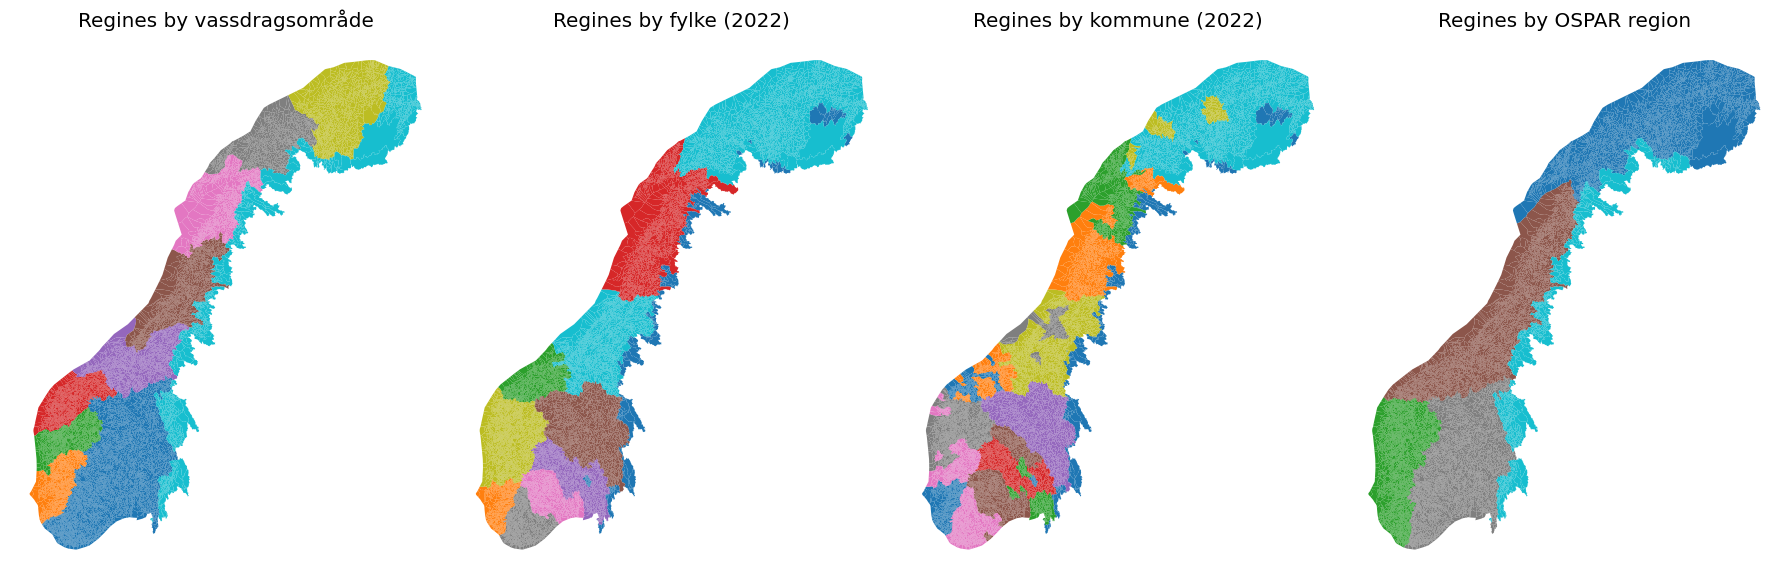

In [8]:
# Plot
admin_year_plot = 2022

fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(18, 6))
reg_gdf.plot(column="vassom", categorical=True, ax=axes[0])
reg_gdf.plot(column=f"fylnr_{admin_year_plot}", categorical=True, ax=axes[1])
reg_gdf.plot(column=f"komnr_{admin_year_plot}", categorical=True, ax=axes[2])
reg_gdf.plot(column="ospar_region", categorical=True, ax=axes[3])
axes[0].set_title("Regines by vassdragsområde")
axes[1].set_title(f"Regines by fylke ({admin_year_plot})")
axes[2].set_title(f"Regines by kommune ({admin_year_plot})")
axes[3].set_title("Regines by OSPAR region")
for ax in axes:
    ax.set_axis_off()
plt.tight_layout()

## 3. Land cover proportions

TEOTIL currently considers the following broad land cover classes:

 * Urban
 * Woodland
 * Agricultural
 * Upland
 * Glacier
 * Sea
 * Lake

**Note:** As above, some regines lie entirely outside of Norway and are therefore not covered by AR50. I have classed these as 100% "other/not mapped" (`artype = 99`) in the code below.

In [9]:
%%time

ar50_gdf = gpd.read_file(ar50_gdb, driver="fileGDB", layer="org_ar_ar50_flate")
reg_gdf = teo.preprocessing.calculate_ar50_land_cover_proportions(reg_gdf, ar50_gdf)
reg_gdf.head()

/opt/conda/lib/python3.11/site-packages/pyogrio/raw.py:194: RuntimeWarning: driver OpenFileGDB does not support open option DRIVER
  result = ogr_read(
/opt/conda/lib/python3.11/site-packages/pyogrio/raw.py:194: RuntimeWarning: organizePolygons() received a polygon with more than 100 parts. The processing may be really slow.  You can skip the processing by setting METHOD=SKIP, or only make it analyze counter-clock wise parts by setting METHOD=ONLY_CCW if you can assume that the outline of holes is counter-clock wise defined
  result = ogr_read(


Reclassifying...
Reprojecting to equal area...
Intersecting polygons...
Aggregating...


/home/jovyan/projects/teotil3/teotil3/preprocessing.py:249: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  reg_gdf[col].fillna(0, inplace=True)


CPU times: user 12min 59s, sys: 49.4 s, total: 13min 49s
Wall time: 13min 49s


regine vassom  a_cat_poly_km2  upstr_a_km2 ospar_region komnr_2014  \
0    001.10    001        1.442790         0.00    Skagerrak       0101   
1   001.1A1    001        1.432479       777.90    Skagerrak       0101   
2  001.1A20    001        0.340160       777.90    Skagerrak       0101   
3  001.1A2A    001       17.647822        58.96    Skagerrak       0101   
4  001.1A2B    001       41.298255        41.30    Skagerrak       0101   

  fylnr_2014 komnr_2015 fylnr_2015 komnr_2016  ... a_glacier_km2 a_lake_km2  \
0         01       0101         01       0101  ...           0.0   0.000013   
1         01       0101         01       0101  ...           0.0   0.048098   
2         01       0101         01       0101  ...           0.0   0.036623   
3         01       0101         01       0101  ...           0.0   0.122567   
4         01       0101         01       0101  ...           0.0   7.513687   

    a_other_km2 a_sea_km2 a_upland_km2 a_urban_km2 a_wood_km2 ar50_tot_a_km2  \
0  3.116485e-01  0.281940     0.000000    0.000000   0.849188       0.849201   
1  2.223036e-03  0.000067     0.004615    0.000000   1.377476       1.430189   
2  0.000000e+00  0.000045     0.000000    0.000000   0.303492       0.340114   
3  0.000000e+00  0.000000     0.467374    0.131585  15.030746      17.647822   
4  1.421085e-13  0.000000     2.250799    0.161524  29.798394      41.298255   

  a_cat_land_km2                                           geometry  
0       1.160850  POLYGON ((297006.83 6543966.95, 297169.29 6543...  
1       1.432412  POLYGON ((297505.44 6543157.79, 297543.1 65430...  
2       0.340114  POLYGON ((297770.368 6543429.036, 297787.114 6...  
3      17.647822  POLYGON ((299678.37 6544460.32, 299667.22 6544...  
4      41.298255  POLYGON ((303353.46 6552989.33, 303341.62 6552...  

[5 rows x 38 columns]

## 4. NVE lake areas

For comparison with AR50, it seems sensible to summarise lake areas per regine from the NVE dataset as well.

**Note:** In many cases, especially in the far north of the country, areas identified as "lakes" by NVE are classed as "myr" in AR50 (`artype = 60`). I'm not sure how best to resolve this at present.

In [10]:
%%time

lake_gdf = gpd.read_file(nve_gdb, driver="fileGDB", layer="Innsjo")
reg_gdf = teo.preprocessing.calculate_nve_regine_lake_areas(reg_gdf, lake_gdf)
reg_gdf.head()

/opt/conda/lib/python3.11/site-packages/pyogrio/raw.py:194: RuntimeWarning: driver OpenFileGDB does not support open option DRIVER
  result = ogr_read(
/opt/conda/lib/python3.11/site-packages/pyogrio/geopandas.py:49: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  res = pd.to_datetime(ser, **datetime_kwargs)
/home/jovyan/projects/teotil3/teotil3/preprocessing.py:308: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  

CPU times: user 1min 18s, sys: 6.66 s, total: 1min 24s
Wall time: 1min 24s


regine vassom  a_cat_poly_km2  upstr_a_km2 ospar_region komnr_2014  \
0    001.10    001        1.442790         0.00    Skagerrak       0101   
1   001.1A1    001        1.432479       777.90    Skagerrak       0101   
2  001.1A20    001        0.340160       777.90    Skagerrak       0101   
3  001.1A2A    001       17.647822        58.96    Skagerrak       0101   
4  001.1A2B    001       41.298255        41.30    Skagerrak       0101   

  fylnr_2014 komnr_2015 fylnr_2015 komnr_2016  ... a_lake_km2   a_other_km2  \
0         01       0101         01       0101  ...   0.000013  3.116485e-01   
1         01       0101         01       0101  ...   0.048098  2.223036e-03   
2         01       0101         01       0101  ...   0.036623  0.000000e+00   
3         01       0101         01       0101  ...   0.122567  0.000000e+00   
4         01       0101         01       0101  ...   7.513687  1.421085e-13   

  a_sea_km2 a_upland_km2 a_urban_km2 a_wood_km2 ar50_tot_a_km2 a_cat_land_km2  \
0  0.281940     0.000000    0.000000   0.849188       0.849201       1.160850   
1  0.000067     0.004615    0.000000   1.377476       1.430189       1.432412   
2  0.000045     0.000000    0.000000   0.303492       0.340114       0.340114   
3  0.000000     0.467374    0.131585  15.030746      17.647822      17.647822   
4  0.000000     2.250799    0.161524  29.798394      41.298255      41.298255   

  a_lake_nve_km2                                           geometry  
0       0.000000  POLYGON ((297006.83 6543966.95, 297169.29 6543...  
1       0.043955  POLYGON ((297505.44 6543157.79, 297543.1 65430...  
2       0.000000  POLYGON ((297770.368 6543429.036, 297787.114 6...  
3       0.186340  POLYGON ((299678.37 6544460.32, 299667.22 6544...  
4       7.344123  POLYGON ((303353.46 6552989.33, 303341.62 6552...  

[5 rows x 39 columns]

## 5. Summarise hydrological characteristics

The code below first fills NoData gaps in NVE's gridded runoff using either bilinear or nearest-neighbour interpolation. This ensures that all regines have a valid runoff value (or almost all if the bilinear grid is used). 

**The code cell immediately below does not need to be re-run unless the raw input grid is modified**.

In [11]:
# # Interpolation method ('linear' or 'nearest')
# method = "linear"

# # Interpolate
# da = rio.open_rasterio(ro_grid_path, masked=True)
# filled_da = da.rio.interpolate_na(method=method)

# # Save
# ro_grid_path_filled = f"/home/jovyan/shared/common/teotil3/nve_hbv_data/runoff_1991-2020_mm_year_{method}_interp.tif"
# filled_da.rio.to_raster(ro_grid_path_filled)

In [12]:
%%time

# Choose dataset to use (None, 'nearest' or 'linear')
interp_method = "linear"

if interp_method:
    grid_path = f"/home/jovyan/shared/common/teotil3/nve_hbv_data/runoff_1991-2020_mm_year_{interp_method}_interp.tif"
else:
    grid_path = ro_grid_path

reg_gdf = teo.preprocessing.summarise_regine_hydrology(
    reg_gdf, grid_path, all_touched=True
)
reg_gdf.head()

CPU times: user 2min 14s, sys: 12.9 s, total: 2min 27s
Wall time: 2min 42s


/home/jovyan/projects/teotil3/teotil3/preprocessing.py:100: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  reg_gdf["runoff_mm/yr"].fillna(0, inplace=True)


regine vassom  a_cat_poly_km2  upstr_a_km2 ospar_region komnr_2014  \
0    001.10    001        1.442790         0.00    Skagerrak       0101   
1   001.1A1    001        1.432479       777.90    Skagerrak       0101   
2  001.1A20    001        0.340160       777.90    Skagerrak       0101   
3  001.1A2A    001       17.647822        58.96    Skagerrak       0101   
4  001.1A2B    001       41.298255        41.30    Skagerrak       0101   

  fylnr_2014 komnr_2015 fylnr_2015 komnr_2016  ... a_sea_km2 a_upland_km2  \
0         01       0101         01       0101  ...  0.281940     0.000000   
1         01       0101         01       0101  ...  0.000067     0.004615   
2         01       0101         01       0101  ...  0.000045     0.000000   
3         01       0101         01       0101  ...  0.000000     0.467374   
4         01       0101         01       0101  ...  0.000000     2.250799   

  a_urban_km2 a_wood_km2 ar50_tot_a_km2 a_cat_land_km2 a_lake_nve_km2  \
0    0.000000   0.849188       0.849201       1.160850       0.000000   
1    0.000000   1.377476       1.430189       1.432412       0.043955   
2    0.000000   0.303492       0.340114       0.340114       0.000000   
3    0.131585  15.030746      17.647822      17.647822       0.186340   
4    0.161524  29.798394      41.298255      41.298255       7.344123   

  runoff_mm/yr q_cat_m3/s                                           geometry  
0          592    0.02178  POLYGON ((297006.83 6543966.95, 297169.29 6543...  
1          620    0.02814  POLYGON ((297505.44 6543157.79, 297543.1 65430...  
2          594    0.00640  POLYGON ((297770.368 6543429.036, 297787.114 6...  
3          637    0.35623  POLYGON ((299678.37 6544460.32, 299667.22 6544...  
4          637    0.83362  POLYGON ((303353.46 6552989.33, 303341.62 6552...  

[5 rows x 41 columns]

## 6. Save dataset

The final regine dataset can now be saved for use later.

In [13]:
# Round numeric columns to sensible precision
num_cols = list(reg_gdf.select_dtypes("number"))
for col in num_cols:
    if col.split("_")[-1] == "km2":
        reg_gdf[col] = reg_gdf[col].round(6)
    elif col.split("_")[-1] == "mm/yr":
        reg_gdf[col] = reg_gdf[col].round(0).astype(int)
    elif col.split("_")[-1] == "m3/s":
        reg_gdf[col] = reg_gdf[col].round(6)
    else:
        pass

In [14]:
teo.io.geodataframe_to_geopackage(
    reg_gdf,
    teo_gpkg,
    "regines",
    attrib_tab_csv=reg_csv,
)

## 7. Basic checking

In [15]:
# Read saved data
reg_gdf = gpd.read_file(teo_gpkg, layer="regines", driver="GPKG")

# Check for NaN
pd.isna(reg_gdf).sum(axis="rows")

/opt/conda/lib/python3.11/site-packages/pyogrio/raw.py:194: RuntimeWarning: driver GPKG does not support open option DRIVER
  result = ogr_read(


regine            0
vassom            0
a_cat_poly_km2    0
upstr_a_km2       0
ospar_region      0
komnr_2014        0
fylnr_2014        0
komnr_2015        0
fylnr_2015        0
komnr_2016        0
fylnr_2016        0
komnr_2017        0
fylnr_2017        0
komnr_2018        0
fylnr_2018        0
komnr_2019        0
fylnr_2019        0
komnr_2020        0
fylnr_2020        0
komnr_2021        0
fylnr_2021        0
komnr_2022        0
fylnr_2022        0
komnr_2023        0
fylnr_2023        0
komnr_2024        0
fylnr_2024        0
a_agri_km2        0
a_glacier_km2     0
a_lake_km2        0
a_other_km2       0
a_sea_km2         0
a_upland_km2      0
a_urban_km2       0
a_wood_km2        0
ar50_tot_a_km2    0
a_cat_land_km2    0
a_lake_nve_km2    0
runoff_mm/yr      0
q_cat_m3/s        0
geometry          0
dtype: int64

### 7.1. Compare NVE's regine areas to totals from AR50

`ar50_tot_a_km2` is defined as the sum of AR50 classes that are not `sea` or `other`. 

Note that most of the differences are along Norway's eastern border, where the regines extend into Sweden/Finland, but AR50 stops. This is why `a_cat_land_km2` is always larger than `ar50_tot_a_km2`.

In [16]:
alt.Chart(reg_gdf[["regine", "a_cat_land_km2", "ar50_tot_a_km2"]]).mark_circle(
    size=60
).encode(
    x="a_cat_land_km2",
    y="ar50_tot_a_km2",
    # color='Origin',
    tooltip=["regine", "a_cat_land_km2", "ar50_tot_a_km2"],
).interactive()

/opt/conda/lib/python3.11/site-packages/altair/utils/core.py:384: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)


alt.Chart(...)

### 7.2. Compare NVE's lake areas to totals from AR50

There are some surprising differences between NVE's lakes database and AR50. In particular:

 * Areas classified as lakes by NVE are often designated "myr" in AR50 (especially in the far north)
 * There are some obvious lakes/large bodies of freshwater missing from NVE's database. For example, the area [here](https://www.google.com/maps/search/?api=1&query=61.86141262616309,8.515057011399492) is not a lake according to NVE

In [17]:
alt.Chart(reg_gdf[["regine", "a_lake_nve_km2", "a_lake_km2"]]).mark_circle(
    size=60
).encode(
    x="a_lake_nve_km2",
    y="a_lake_km2",
    # color='Origin',
    tooltip=["regine", "a_lake_nve_km2", "a_lake_km2"],
).interactive()

/opt/conda/lib/python3.11/site-packages/altair/utils/core.py:384: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)


alt.Chart(...)